In [68]:
import os
import re
import json
import warnings
from dataclasses import dataclass
from typing import List, Dict, Optional, Tuple

import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import pearsonr, spearmanr

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, StratifiedKFold, StratifiedGroupKFold,KFold,cross_val_predict
from sklearn.utils.validation import check_is_fitted
from joblib import Parallel, delayed

In [69]:
base_path = "/neurospin/dico/data/deep_folding/current/models/Champollion_V1_after_ablation"

In [70]:
def _normalize_ids(s: pd.Series) -> pd.Series:
    # tout en str, sans espaces, en minuscules
    s = s.astype(str).str.strip().str.lower()
    # retire 'sub-' s'il est présent
    s = s.str.replace(r'^(sub-)', '', regex=True)
    return s



def load_cognition_df() -> pd.DataFrame:
    path = "/neurospin/dico/rmenasria/Runs/03_main/Input/dHCP/cognitive_scores_with_age_dHCP.csv"
    df = pd.read_csv(path)
    if "Participant ID" not in df.columns:
        raise ValueError("Colonne 'Participant ID' absente du CSV de cognition.")
    df["pid_norm"] = _normalize_ids(df["Participant ID"])
    # enlève les doublons éventuels côté cognition (garde le premier)
    df = df.drop_duplicates(subset=["pid_norm"], keep="first")
    return df



def load_embeddings_dHCP(region):
    region_path = os.path.join(base_path, region)
    subdirs = [d for d in os.listdir(region_path) if os.path.isdir(os.path.join(region_path, d))]
    if len(subdirs) != 1:
        raise RuntimeError(
            f"Il y a {len(subdirs)} sous-dossiers dans {region_path}, impossible de choisir automatiquement."
        )
    model_folder = subdirs[0]
    embedding_path = os.path.join(region_path, model_folder, "dHCP_random_embeddings", "full_embeddings.csv")
    embeddings = pd.read_csv(embedding_path, index_col=0)

    # index -> pid_norm
    embeddings.index = _normalize_ids(embeddings.index)
    embeddings.index.name = "pid_norm"

    # dédoublonne si besoin (garde la première occurrence)
    embeddings = embeddings[~embeddings.index.duplicated(keep="first")]

    print("embeddings shape (avant filtre cognition):", embeddings.shape)
    return embeddings




In [71]:
class ResidualizerSexeFromX(BaseEstimator, TransformerMixin):
    """
    Suppose que la dernière colonne de X est le sexe binaire {0,1}.
    - fit : pour chaque feature j, ajuste x_j ~ a_j + b_j*sexe
    - transform : retourne les résidus (x_j - prédiction), en enlevant la colonne sexe.
    """
    def __init__(self, sex_col_index: int = -1):
        self.sex_col_index = sex_col_index

    def fit(self, X, y=None):
        X = np.asarray(X, dtype=float)
        sex = X[:, self.sex_col_index]
        feats = np.delete(X, self.sex_col_index, axis=1)

        # Vérif binaire
        uniq = np.unique(sex[~np.isnan(sex)])
        if not np.all(np.isin(uniq, [0.0, 1.0])):
            warnings.warn("Colonne sexe pas strictement binaire {0,1}.")

        # Formules fermées de la régression OLS par dimension
        s_mean, s_var = np.nanmean(sex), np.nanvar(sex)
        X_mean = np.nanmean(feats, axis=0)

        if s_var <= 0:
            beta = np.zeros(feats.shape[1])
            alpha = X_mean.copy()
        else:
            cov = np.nanmean((feats - X_mean) * (sex[:, None] - s_mean), axis=0)
            beta = cov / s_var
            alpha = X_mean - beta * s_mean

        self.alpha_ = alpha
        self.beta_ = beta
        self.n_features_ = feats.shape[1]
        self.sex_col_index_ = self.sex_col_index
        return self

    def transform(self, X):
        check_is_fitted(self, ["alpha_", "beta_"])
        X = np.asarray(X, dtype=float)
        sex = X[:, self.sex_col_index_]
        feats = np.delete(X, self.sex_col_index_, axis=1)
        pred = self.alpha_[None, :] + sex[:, None] * self.beta_[None, :]
        return feats - pred

In [72]:
@dataclass
class PreparedData:
    X: np.ndarray            # embeddings + sexe concaténés
    y: np.ndarray
    groups: np.ndarray
    idx_keep: np.ndarray
    embedding_cols: List[str]
    n_splits: int


def prepare_dhcp_for_score(
    region: str,
    cognition_col: str,
    prem_class: Optional[List[str]] = None,
    sex_col: str = "Child's Sex",
    group_col: Optional[str] = None,
    min_splits: int = 5
) -> PreparedData:
    emb_df = load_embeddings_dHCP(region)
    cog_df = load_cognition_df()

    # Sanity checks colonnes
    if cognition_col not in cog_df.columns:
        raise ValueError(f"Colonne cognition '{cognition_col}' absente du df cognition.")
    if sex_col not in cog_df.columns:
        raise ValueError(f"Colonne sexe '{sex_col}' absente du df cognition.")

    # Merge sur pid_norm
    merged = cog_df.merge(emb_df, on="pid_norm", how="inner", suffixes=("", "_emb"))
    print(f"[{region} | {cognition_col}] après merge: {merged.shape[0]} sujets")

    if merged.empty:
        # aide au debug: montre quelques IDs qui ne matchent pas
        miss_left = set(cog_df["pid_norm"]) - set(emb_df.index)
        miss_right = set(emb_df.index) - set(cog_df["pid_norm"])
        print("Exemples d'IDs cognition sans embedding:", list(miss_left)[:10])
        print("Exemples d'IDs embedding sans cognition:", list(miss_right)[:10])
        raise ValueError("Merge vide — vérifier la normalisation des IDs.")

    # Filtre prématurés (si demandé et colonne présente)
    if prem_class is not None:
        if "prem_class" in merged.columns:
            before = merged.shape[0]
            merged = merged[merged["prem_class"].isin(prem_class)].copy()
            print(f"Filtre prem_class {prem_class}: {before} -> {merged.shape[0]}")
        else:
            warnings.warn("prem_class demandé mais colonne 'prem_class' absente; filtre ignoré.")

    # map sexe → numérique
    sex_map = {"male": 0, "female": 1, "m": 0, "f": 1}
    merged["_sex_num"] = _normalize_ids(merged[sex_col]).map(sex_map).astype(float)

    # embeddings
    embedding_cols = [c for c in merged.columns if re.match(r"^dim", c)]
    if not embedding_cols:
        raise ValueError("Aucune colonne d'embeddings 'dim...' trouvée après merge.")

    X_emb = merged[embedding_cols].values.astype(float)
    y = merged[cognition_col].values.astype(float)
    sex_vec = merged["_sex_num"].values.astype(float)

    # groups: par défaut = pid_norm
    if group_col is None:
        groups = merged["pid_norm"].astype(str).values
    else:
        if group_col not in merged.columns:
            raise ValueError(f"Colonne de groupe '{group_col}' absente du merged.")
        groups = merged[group_col].astype(str).values

    # clean rows: drop si y ou sex NA
    keep = (~np.isnan(y)) & (~np.isnan(sex_vec))
    X_emb, y, sex_vec, groups = X_emb[keep], y[keep], sex_vec[keep], groups[keep]

    # concatène sexe en dernière colonne 
    X_aug = np.column_stack([X_emb, sex_vec])

    try:
        y_strat = pd.qcut(y, q=3, labels=False, duplicates="drop")
    except Exception:
        y_strat = np.zeros_like(y, dtype=int)

    # Ajuste n_splits si une classe est trop petite
    counts = pd.Series(y_strat).value_counts()
    max_splits = int(counts.min()) if not counts.empty else 2
    n_splits = max(2, min(min_splits, max_splits))
    if n_splits < min_splits:
        warnings.warn(f"Stratification limitée: plus petite classe={max_splits}, n_splits={n_splits}.")

    return PreparedData(
        X=X_aug, y=y, groups=groups, idx_keep=keep,
        embedding_cols=embedding_cols + ["_sex_num"], n_splits=n_splits
    )


In [73]:
def _cv_pred_mean_repeats(X, y, groups, alpha, repeats=50, n_splits=5, seed=0, n_jobs=-1):
    rng = np.random.default_rng(seed)
    preds = []

    def _stratify(v):
        try:
            return pd.qcut(v, q=3, labels=False, duplicates="drop")
        except Exception:
            return np.zeros_like(v, dtype=int)

    for r in range(repeats):
        y_strat = _stratify(y)
        sgkf = StratifiedGroupKFold(
            n_splits=n_splits,
            shuffle=True,
            random_state=int(rng.integers(0, 1_000_000))
        )
        pipe_fixed = Pipeline([
            ('resid', ResidualizerSexeFromX()),
            ('scaler', StandardScaler()),
            ('regressor', Ridge(alpha=alpha))
        ])
        y_pred_r = cross_val_predict(
            pipe_fixed, X, y,
            cv=sgkf.split(X, y_strat, groups),
            n_jobs=n_jobs
        )
        preds.append(y_pred_r)

    return np.mean(np.column_stack(preds), axis=1)


def _perm_test_corr(y_true, y_pred_fixed, n_perm=1000, seed=0, side='greater'):
    rng = np.random.default_rng(seed)
    r_obs = pearsonr(y_true, y_pred_fixed)[0]
    null = []
    for _ in range(n_perm):
        y_perm = rng.permutation(y_true)
        null.append(pearsonr(y_perm, y_pred_fixed)[0])
    null = np.asarray(null)

    if side == 'greater':
        p = (np.sum(null >= r_obs) + 1) / (n_perm + 1)
    elif side == 'less':
        p = (np.sum(null <= r_obs) + 1) / (n_perm + 1)
    else:
        p = (np.sum(np.abs(null) >= abs(r_obs)) + 1) / (n_perm + 1)

    crit = np.percentile(null, 95.0)  # seuil critique 5% (unilatéral r>0)
    return float(r_obs), float(p), float(crit)


In [74]:
def bootstrap_cv_residualized_sex(
    data: PreparedData,
    random_state: int = 42,
    n_jobs: int = -1,
    alphas: Tuple[float, ...] = (0.01, 0.1, 1.0, 10.0),
    repeats: int = 50,
    n_perm: int = 10000,
    n_boot_ci: int = 5000
) -> Dict:
    """
    Évalue l'association entre embeddings et score cognitif avec :
    - CV groupée et stratifiée répétée (repeats fois),
    - corrélation Pearson hors-échantillon (r_cv_mean_repeats),
    - IC95% bootstrap sujets autour de r_cv_mean_repeats,
    - test de permutation unilatéral (r_perm_pvalue_one_sided).
    """
    rng = np.random.default_rng(random_state)
    X, y, groups = data.X, data.y, data.groups

    # Choix de alpha via GridSearchCV
    pipe = Pipeline([
        ('resid', ResidualizerSexeFromX()),
        ('scaler', StandardScaler()),
        ('regressor', Ridge())
    ])
    inner = KFold(n_splits=min(5, data.n_splits), shuffle=True, random_state=0)

    grid = GridSearchCV(
        pipe, {'regressor__alpha': list(alphas)},
        cv=inner, scoring='r2', n_jobs=n_jobs
    )
    grid.fit(X, y)
    best_alpha = float(grid.best_params_['regressor__alpha'])

    # CV répétée : prédictions moyennées par sujet
    y_pred_mean = _cv_pred_mean_repeats(
        X, y, groups,
        alpha=best_alpha,
        repeats=repeats,
        n_splits=data.n_splits,
        seed=random_state,
        n_jobs=n_jobs
    )

    # Corrélation observée + test permutation 
    r_cv, p_perm, r_crit_95 = _perm_test_corr(
        y_true=y,
        y_pred_fixed=y_pred_mean,
        n_perm=n_perm,
        seed=random_state,
        side='greater'
    )

    # Bootstrap sujets pour IC autour de r_cv
    def ci_bootstrap_on_subjects(y_true, y_pred, n_boot=5000, seed=0):
        rng = np.random.default_rng(seed)
        n = len(y_true)
        rs = []
        for _ in range(n_boot):
            idx = rng.integers(0, n, size=n)
            try:
                rs.append(pearsonr(y_true[idx], y_pred[idx])[0])
            except Exception:
                rs.append(np.nan)
        rs = np.array(rs, dtype=float)
        ci = np.nanpercentile(rs, [2.5, 97.5]).tolist()
        return float(np.nanmean(rs)), ci

    r_mean_stable, r_ci_stable = ci_bootstrap_on_subjects(
        y, y_pred_mean, n_boot=n_boot_ci, seed=random_state
    )

    # Résultats
    out = {
        "n": int(len(y)),
        "best_alpha": best_alpha,
        "r_cv_mean_repeats": r_cv,
        "r_cv_mean_repeats_ci": r_ci_stable,
        "r_perm_pvalue_one_sided": p_perm,
        "r_null_95pct": r_crit_95
    }
    return out


In [75]:
def run_regions_scores(
    regions: List[str],
    scores: List[str],
    prem_class: Optional[List[str]] = None,
    random_state: int = 42,
    n_jobs_boot: int = -1,
    alphas: Tuple[float, ...] = (0.01, 0.1, 1.0, 10.0),
    repeats: int = 50,
    n_perm: int = 10000,
    n_boot_ci: int = 5000,
    output_csv: Optional[str] = None
) -> pd.DataFrame:
    rows = []
    for region in regions:
        for score in scores:
            try:
                data = prepare_dhcp_for_score(region, score, prem_class=prem_class)
                res = bootstrap_cv_residualized_sex(
                    data,
                    random_state=random_state,
                    n_jobs=n_jobs_boot,
                    alphas=alphas,
                    repeats=repeats,
                    n_perm=n_perm,
                    n_boot_ci=n_boot_ci
                )
                rows.append({
                    "region": region,
                    "score": score,
                    "n": res["n"],
                    "best_alpha": res["best_alpha"],
                    "r_cv_mean_repeats": res["r_cv_mean_repeats"],
                    "r_cv_mean_repeats_ci_low": res["r_cv_mean_repeats_ci"][0],
                    "r_cv_mean_repeats_ci_high": res["r_cv_mean_repeats_ci"][1],
                    "r_perm_pvalue_one_sided": res["r_perm_pvalue_one_sided"],
                    "r_null_95pct": res["r_null_95pct"],
                })

            except Exception as e:
                warnings.warn(f"[{region} | {score}] failed: {e}")
    df = pd.DataFrame(rows)
    if output_csv:
        df.to_csv(output_csv, index=False)
    return df


In [ ]:
# Exemples de régions & scores 
regions = [
    "SFinf-BROCA-SPeCinf_right",
    "SFinf-BROCA-SPeCinf_left",
    "ScCal-SLi_left",
    "STi-SOTlat_right",
    "FColl-SRh_right",
]

emb = load_embeddings_dHCP(regions[0])
cog = load_cognition_df()
print("n embeddings:", emb.shape, "n cognition:", cog.shape)
print("intersection IDs:", len(set(emb.index) & set(cog["pid_norm"])))
scores = [
    "Composite Score",
    "Communication Composite Score",
    "Receptive Communication Scaled Score",
    "Expressive Communication Scaled Score",
    "Sum Communication Scaled Scores",
]
# filtrer prématurés
prem_filter = ['<28','28-32','32-37']  # mettre None pour désactiver

out = run_regions_scores(
    regions=regions,
    scores=scores,
    prem_class=prem_filter,
    random_state=42,
    n_jobs_boot=-1,
    alphas=(0.01, 0.1, 1.0, 10.0),
    repeats=50,
    n_perm=10000,
    n_boot_ci=750,  
    output_csv="/neurospin/dico/rmenasria/Runs/03_main/Output/final/r_boostraped/dhcp_bootstrap_cognition_perm_resampled.csv" 
)
print(out)

embeddings shape (avant filtre cognition): (374, 32)
n embeddings: (374, 32) n cognition: (354, 15)
intersection IDs: 354
embeddings shape (avant filtre cognition): (374, 32)
[SFinf-BROCA-SPeCinf_right | Composite Score] après merge: 354 sujets
Filtre prem_class ['<28', '28-32', '32-37']: 354 -> 79
embeddings shape (avant filtre cognition): (374, 32)
[SFinf-BROCA-SPeCinf_right | Communication Composite Score] après merge: 354 sujets
Filtre prem_class ['<28', '28-32', '32-37']: 354 -> 79
embeddings shape (avant filtre cognition): (374, 32)
[SFinf-BROCA-SPeCinf_right | Receptive Communication Scaled Score] après merge: 354 sujets
Filtre prem_class ['<28', '28-32', '32-37']: 354 -> 79
embeddings shape (avant filtre cognition): (374, 32)
[SFinf-BROCA-SPeCinf_right | Expressive Communication Scaled Score] après merge: 354 sujets
Filtre prem_class ['<28', '28-32', '32-37']: 354 -> 79
embeddings shape (avant filtre cognition): (374, 32)
[SFinf-BROCA-SPeCinf_right | Sum Communication Scaled Sc

/tmp/ipykernel_565985/1239843407.py:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot = annot.applymap(lambda p: "*" if p < 0.05/10 else "")


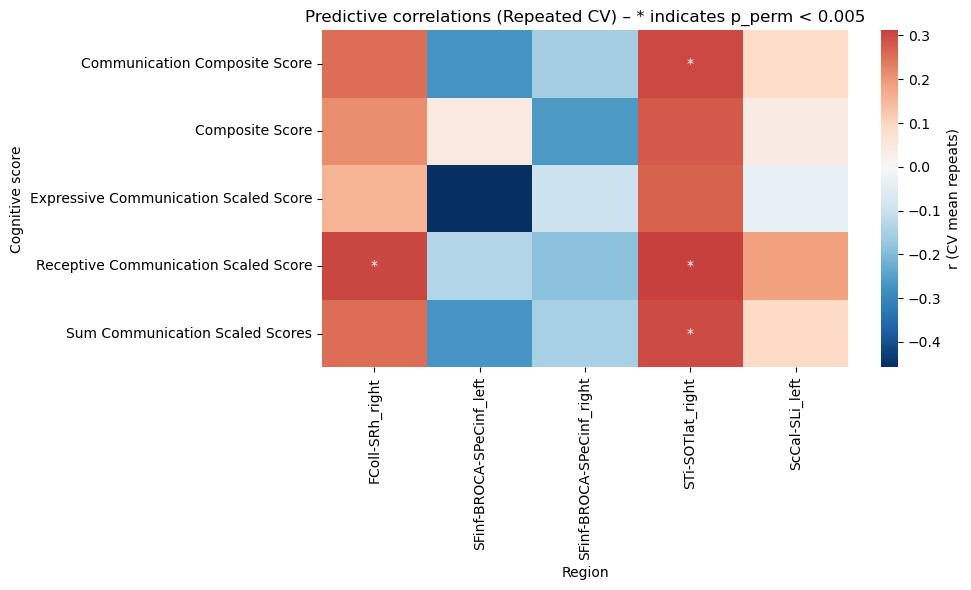

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv("/neurospin/dico/rmenasria/Runs/03_main/Output/final/r_boostraped/dhcp_bootstrap_cognition_perm_resampled.csv")

df_small = df[[
    "region",
    "score",
    "r_cv_mean_repeats",
    "r_perm_pvalue_one_sided"
]]


# Pivot for the heatmap
pivot = df_small.pivot(index="score", columns="region", values="r_cv_mean_repeats")

# Create annotation matrix (* if p < 0.005)
annot = df_small.pivot(index="score", columns="region", values="r_perm_pvalue_one_sided")
annot = annot.applymap(lambda p: "*" if p < 0.05/10 else "")

# Heatmap
plt.figure(figsize=(10,6))
ax = sns.heatmap(
    pivot, annot=annot, fmt="", cmap="RdBu_r", center=0,
    cbar_kws={"label": "r (CV mean repeats)"}
)
plt.title("Predictive correlations (Repeated CV) – * indicates p_perm < 0.005")
plt.ylabel("Cognitive score")
plt.xlabel("Region")
plt.tight_layout()
plt.show()


/tmp/ipykernel_565985/1923742086.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.26
[0.05; 0.46]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  annot.loc[i, j] = make_label(
/tmp/ipykernel_565985/1923742086.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.27
[-0.45; -0.10]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  annot.loc[i, j] = make_label(
/tmp/ipykernel_565985/1923742086.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.15
[-0.34; 0.01]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  annot.loc[i, j] = make_label(
/tmp/ipykernel_565985/1923742086.py:34: FutureWarning: Setting an it

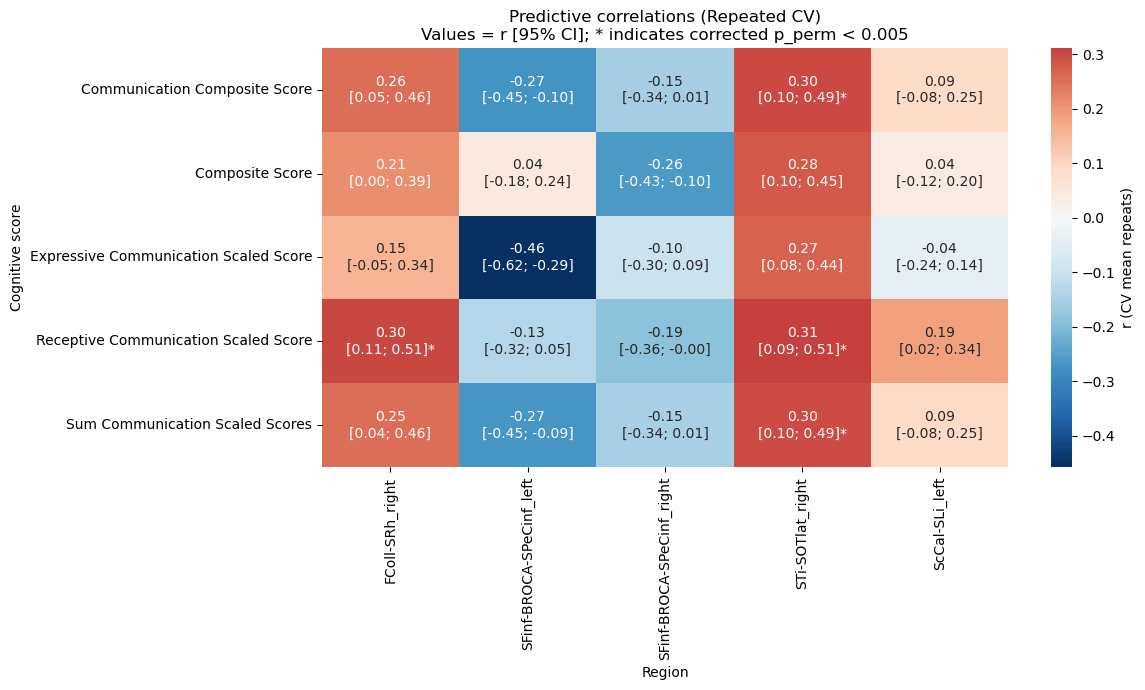

In [ ]:
df = pd.read_csv(
    "/neurospin/dico/rmenasria/Runs/03_main/Output/final/r_boostraped/dhcp_bootstrap_cognition_perm_resampled.csv"
)

df_small = df[[
    "region",
    "score",
    "r_cv_mean_repeats",
    "r_cv_mean_repeats_ci_low",
    "r_cv_mean_repeats_ci_high",
    "r_perm_pvalue_one_sided"
]]

pivot = df_small.pivot(index="score", columns="region", values="r_cv_mean_repeats")

# Create annotation matrix with r + CI + star
def make_label(r, low, high, pval):
    if pd.isna(r):
        return ""
    star = "*" if pval < 0.05/10 else ""
    return f"{r:.2f}\n[{low:.2f}; {high:.2f}]{star}"

annot = df_small.pivot(index="score", columns="region", values="r_cv_mean_repeats").copy()
for i in annot.index:
    for j in annot.columns:
        row = df_small[(df_small["score"] == i) & (df_small["region"] == j)].iloc[0]
        annot.loc[i, j] = make_label(
            row["r_cv_mean_repeats"],
            row["r_cv_mean_repeats_ci_low"],
            row["r_cv_mean_repeats_ci_high"],
            row["r_perm_pvalue_one_sided"]
        )

# Heatmap
plt.figure(figsize=(12, 7))
ax = sns.heatmap(
    pivot, annot=annot, fmt="", cmap="RdBu_r", center=0,
    cbar_kws={"label": "r (CV mean repeats)"}
)
plt.title("Predictive correlations (Repeated CV)\nValues = r [95% CI]; * indicates corrected p_perm < 0.005")
plt.ylabel("Cognitive score")
plt.xlabel("Region")
plt.tight_layout()
plt.show()
